# NeuroFusion: Neural Style Transfer

**NeuroFusion** is a project that implements the **Neural Style Transfer (NST)** algorithm to create artistic images by blending the content of one image with the style of another.

NST leverages **deep learning techniques** to optimize pixel values, generating a unique artistic style while preserving the essential content of the original image. The algorithm works by:

- **Comparing** the content and style of the reference images.
- **Adjusting** the generated image to reflect both content and style.

The result is a **novel artistic creation** that combines the best aspects of both images.


## 1 - Getting Required Files

In [1]:
!git clone "https://github.com/TA-rathnayaka/Art-generator-with-Neural-Style-transfer"

Cloning into 'Art-generator-with-Neural-Style-transfer'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 43 (delta 0), reused 5 (delta 0), pack-reused 37 (from 1)
Receiving objects: 100% (43/43), 81.51 MiB | 21.07 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (10/10), done.


In [2]:
%cd "/content/Art-generator-with-Neural-Style-transfer"

/content/Art-generator-with-Neural-Style-transfer


<a name='2'></a>
## 2 - Packages

In [3]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

<a name='3'></a>
## 3 - Transfer Learning


Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.

This project uses the **VGG-19** network, a pre-trained deep learning model for feature extraction.  


In [4]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

<Functional name=vgg19, built=True>


<a name='4'></a>
## 4 - Neural Style Transfer (NST)

<a name='4-1'></a>
### 4.1 - Computing the Content Cost

In [12]:
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]

    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[_, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[_, -1, n_C])

    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))) / (4 * n_H * n_W * n_C)

    return J_content

<a name='4-2'></a>
### 4.2 - Computing the Style Cost



In [13]:
def gram_matrix(A):

    GA = tf.matmul(A, A, transpose_b=True)
    print(GA)

    return GA

In [14]:
def compute_layer_style_cost(a_S, a_G):
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.reshape(tf.transpose(a_S), shape=[_, n_C ,n_H * n_W])
    a_G = tf.reshape(tf.transpose(a_G), shape=[_, n_C ,n_H * n_W])

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / (4 * ((n_H * n_W) ** 2) * (n_C ** 2))

    return J_style_layer

In [15]:
for layer in vgg.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [16]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [17]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):

    J_style = 0

    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]

    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

<a name='4-3'></a>
### 4.3 - Total Cost to Optimize

In [18]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha * J_content + beta * J_style


    return J

<a name='5'></a>
## 5 - Start Generatating Image (NST)

<a name='5-1'></a>
### 5.1 Load the Content Image


(1, 400, 400, 3)


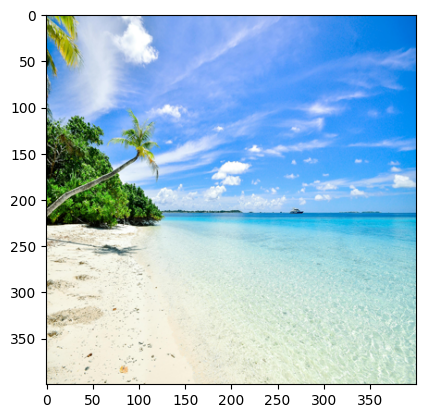

In [20]:
content_image = np.array(Image.open("images/content.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### 5.2 Load the Style Image


(1, 400, 400, 3)


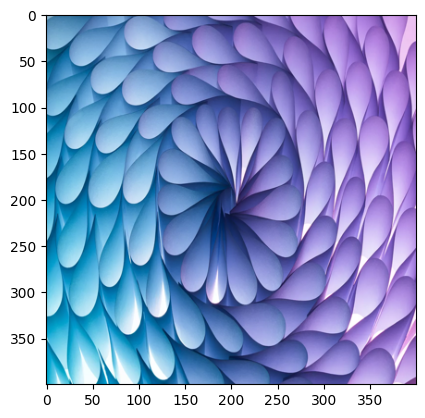

In [21]:
style_image =  np.array(Image.open("images/style.webp").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### 5.3 Randomly Initialize the Image to be Generated


(1, 400, 400, 3)


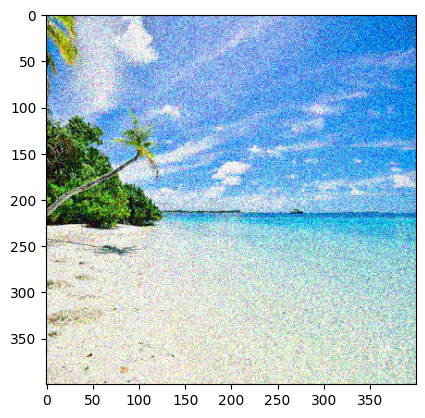

In [22]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32), trainable=True)
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
### 5.4 - Load Pre-trained VGG19 Model


In [23]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [24]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [25]:
content_target = vgg_model_outputs(content_image)
style_targets = vgg_model_outputs(style_image)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 400, 400, 3))
  warnings.warn(msg)


In [26]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [27]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [28]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

In [30]:
generated_image = tf.Variable(generated_image)

In [31]:
!mkdir output/

In [32]:
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

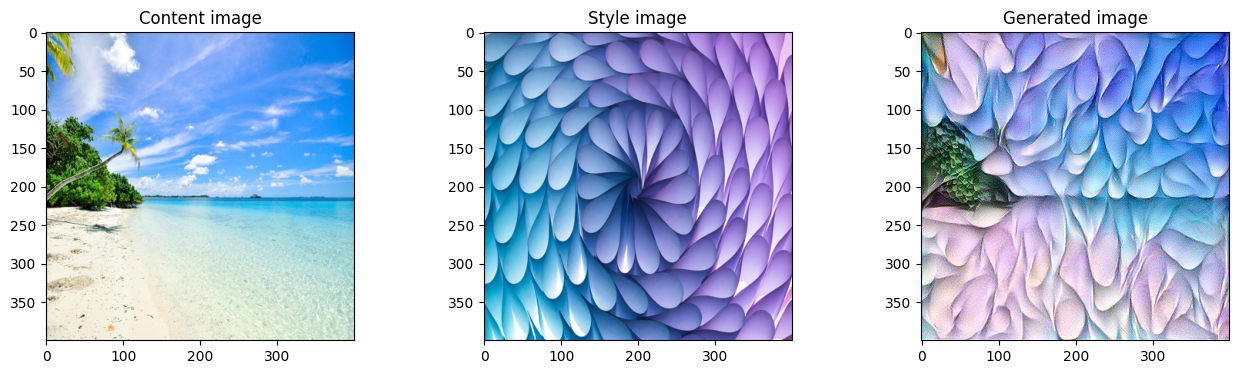

In [33]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()